# **Imorting Necessary Libraries**

In [1]:
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg19 import VGG19
from keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from sklearn.metrics import classification_report, accuracy_score, roc_curve, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
import seaborn as sns
import cv2
import glob

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Difining the Paths for Training, Validation, and Testing Data**

In [3]:
main_path = "/content/drive/MyDrive/chest_xray"

In [4]:
train_path = os.path.join(main_path, "train")
val_path = os.path.join(main_path, "val")
test_path = os.path.join(main_path, "test")

# **Visualizing the Data**

In [5]:
normal_train_images = glob.glob(train_path + "/NORMAL/*.jpeg")
pneumonia_train_images = glob.glob(train_path + "/PNEUMONIA/*.jpeg")

In [6]:
print(len(normal_train_images))
print(len(pneumonia_train_images))

1341
3875


In [7]:
data = pd.DataFrame(np.concatenate([[0] * len(normal_train_images) , [1] *  len(pneumonia_train_images)]), columns = ["class"])

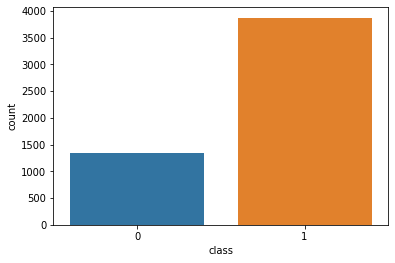

In [8]:
sns.countplot(x = 'class', data = data)

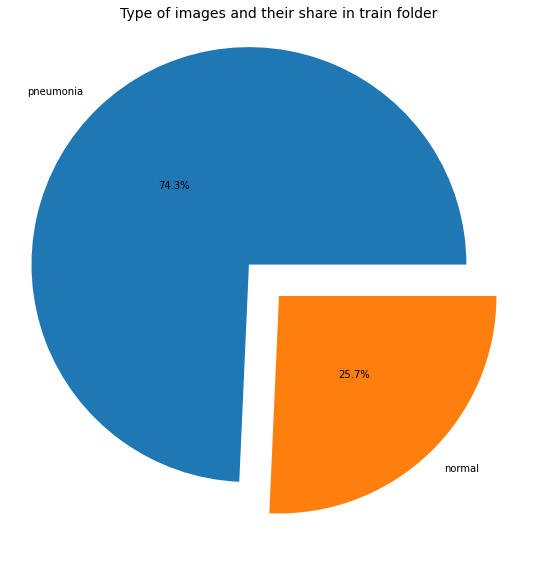

In [9]:
plt.figure(figsize = (15, 10))
plt.pie(x = np.array([len(pneumonia_train_images), len(normal_train_images)]), autopct = "%.1f%%", explode = [0.2, 0], labels = ["pneumonia", "normal"], pctdistance = 0.5)
plt.title("Type of images and their share in train folder", fontsize = 14);

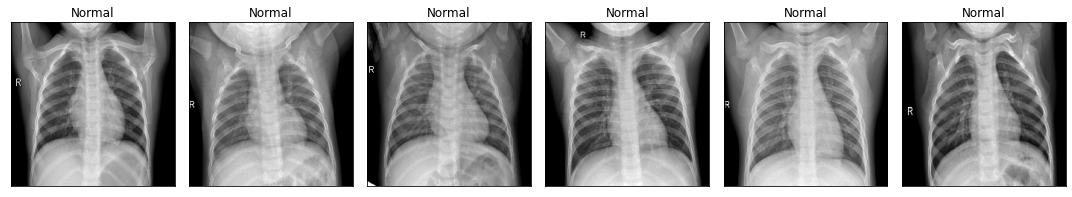

In [10]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(normal_train_images[i])
    img = cv2.resize(img, (220, 220))
    ax.imshow(img)
    ax.set_title("Normal")
fig.tight_layout()    

plt.show()

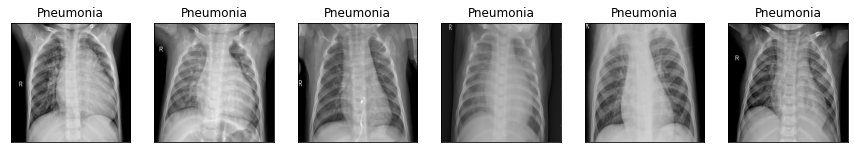

In [11]:
fig, axes = plt.subplots(nrows = 1, ncols = 6, figsize = (15, 10), subplot_kw = {'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    img = cv2.imread(pneumonia_train_images[i])
    img = cv2.resize(img, (512, 512))
    ax.imshow(img)
    ax.set_title("Pneumonia")
    
plt.show()

# **Creating Image Data Generators**

In [12]:
# define the type of augmentation techniques.
train_datagen = ImageDataGenerator(
    rescale = 1. / 255.,
    shear_range = 10,
    zoom_range = 0.2,
    horizontal_flip = True,
    width_shift_range = 0.2,
#     height_shift_range = 0.2,
#     rotation_range = 20,
    fill_mode = 'nearest',
)
val_datagen = ImageDataGenerator(
    rescale = 1. / 255.
)

In [13]:
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size = (220, 220),
    batch_size = 16,
    class_mode = 'binary'
)
validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size = (220,220),
        batch_size = 8,
        class_mode = 'binary'
)
test_generator = val_datagen.flow_from_directory(
    test_path,
    shuffle = False,
    target_size = (220,220),
    batch_size = 32,
    class_mode = 'binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# **Defining the Model**

In [14]:
input_shape = (220, 220, 3)

conv_base = VGG19(include_top = False, input_shape = input_shape, weights = 'imagenet')
for i in conv_base.layers:
    i.trainable = False

X = conv_base.output
X = keras.layers.GlobalAveragePooling2D()(X)
X = keras.layers.Dense(128, activation = 'relu')(X)
predictions = keras.layers.Dense(1, activation = 'sigmoid')(X)
model = keras.Model(conv_base.input, predictions)

initial_learning_rate = 0.1
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 100000,
    decay_rate = 0.96,
    staircase = True)
model.compile(loss = 'binary_crossentropy',
             optimizer = tf.keras.optimizers.RMSprop(lr_schedule),
             metrics = ['accuracy'])

80150528/80134624 [==============================] - 1s 0us/step


In [15]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 220, 220, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 220, 220, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 220, 220, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 110, 110, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 110, 110, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 110, 110, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 55, 55, 128)       0     

# **Training the Model**

In [16]:
history = model.fit(
    train_generator,
    steps_per_epoch = 100,
    epochs = 20,
    validation_data = validation_generator,
)

Epoch 1/20
50/50 [==============================] - 472s 9s/step - loss: 14.9930 - accuracy: 0.5500 - val_loss: 0.4829 - val_accuracy: 0.7500
Epoch 2/20
50/50 [==============================] - 452s 9s/step - loss: 0.4718 - accuracy: 0.7850 - val_loss: 0.5282 - val_accuracy: 0.6875
Epoch 3/20
50/50 [==============================] - 447s 9s/step - loss: 0.5487 - accuracy: 0.7301 - val_loss: 0.5673 - val_accuracy: 0.5000
Epoch 4/20
50/50 [==============================] - 450s 9s/step - loss: 0.4626 - accuracy: 0.7668 - val_loss: 1.1204 - val_accuracy: 0.6875
Epoch 5/20
50/50 [==============================] - 449s 9s/step - loss: 0.4741 - accuracy: 0.8075 - val_loss: 0.7184 - val_accuracy: 0.6250
Epoch 6/20
50/50 [==============================] - 449s 9s/step - loss: 0.4838 - accuracy: 0.7822 - val_loss: 0.6149 - val_accuracy: 0.6875
Epoch 7/20
50/50 [==============================] - 446s 9s/step - loss: 0.4279 - accuracy: 0.7855 - val_loss: 0.9072 - val_accuracy: 0.6875
Epoch 8/20
5

# **Saving the Model**

In [17]:
model.save("model1")

INFO:tensorflow:Assets written to: model1/assets


# **Model Metrics**

In [18]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# **Visualizing Accuracy and Loss**

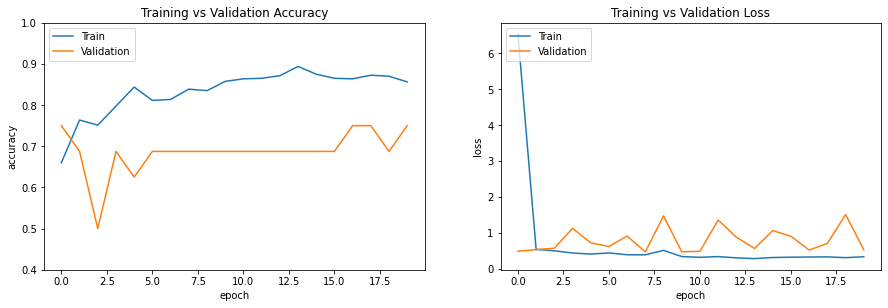

In [19]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# **Predictions**

In [20]:
model = keras.models.load_model('model1')

In [21]:
pred = model.predict(test_generator)

In [22]:
pred

array([[0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.99887097],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.2832386 ],
       [0.39734593],
       [0.2832386 ],
       [0.283

In [23]:
y_pred = []
for prob in pred:
    if prob >= 0.5:
        y_pred.append(1)
    else:
        y_pred.append(0)

In [24]:
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,


In [25]:
y_true = test_generator.classes

In [26]:
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [27]:
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(y_true, y_pred)
print('Accuracy: %f' % accuracy)

Accuracy: 0.846154


In [28]:
# precision tp / (tp + fp)
precision = precision_score(y_true, y_pred)
print('Precision: %f' % precision)

Precision: 0.906077


In [29]:
# recall: tp / (tp + fn)
recall = recall_score(y_true, y_pred)
print('Recall: %f' % recall)

Recall: 0.841026


In [30]:
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_true, y_pred)
print('F1 score: %f' % f1) 

F1 score: 0.872340


In [31]:
# ROC AUC
auc = roc_auc_score(y_true, y_pred)
print('ROC AUC: %f' % auc)

ROC AUC: 0.847863


# **Confusion Matrix**

In [32]:
cm = confusion_matrix(y_true, y_pred)

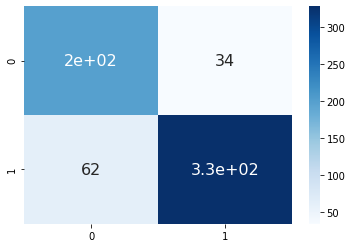

In [33]:
sns.heatmap(cm, annot = True, cmap = "Blues", annot_kws = {"size": 16})

# **Classification Report**

In [34]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.85      0.81       234
           1       0.91      0.84      0.87       390

    accuracy                           0.85       624
   macro avg       0.83      0.85      0.84       624
weighted avg       0.85      0.85      0.85       624



# **Finetuning the Model**

In [35]:
for i in conv_base.layers:
    i.trainable = True

initial_learning_rate = 1e-5
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps = 100000,
    decay_rate = 0.96,
    staircase = True)
model.compile(optimizer = tf.keras.optimizers.RMSprop(lr_schedule),  # Very slow learning rate
              loss = keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = [keras.metrics.BinaryAccuracy()])

In [36]:
model.fit(
    train_generator,
    steps_per_epoch = 50,
    epochs = 100,
    validation_data = validation_generator,
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4982: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


50/50 [==============================] - 450s 9s/step - loss: 0.2634 - binary_accuracy: 0.8807 - val_loss: 0.5253 - val_binary_accuracy: 0.7500
Epoch 2/10
50/50 [==============================] - 447s 9s/step - loss: 0.2471 - binary_accuracy: 0.8969 - val_loss: 0.5265 - val_binary_accuracy: 0.7500
Epoch 3/10
50/50 [==============================] - 447s 9s/step - loss: 0.2479 - binary_accuracy: 0.8688 - val_loss: 0.5278 - val_binary_accuracy: 0.7500
Epoch 4/10
50/50 [==============================] - 448s 9s/step - loss: 0.2738 - binary_accuracy: 0.8614 - val_loss: 0.5293 - val_binary_accuracy: 0.7500
Epoch 5/10
50/50 [==============================] - 447s 9s/step - loss: 0.2776 - binary_accuracy: 0.8719 - val_loss: 0.5304 - val_binary_accuracy: 0.7500
Epoch 6/10
50/50 [==============================] - 447s 9s/step - loss: 0.2565 - binary_accuracy: 0.8748 - val_loss: 0.5317 - val_binary_accuracy: 0.7500
Epoch 7/10
50/50 [==============================] - 447s 9s/step - loss: 0.2672 -

In [37]:
final_accuracy = model.evaluate_generator(test_generator)[1]

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1948: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


In [38]:
final_accuracy

0.8509615659713745

# **Model Metrics**

In [39]:
accuracy = history.history['accuracy']
val_accuracy  = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# **Visualizing Accuracy and Loss**

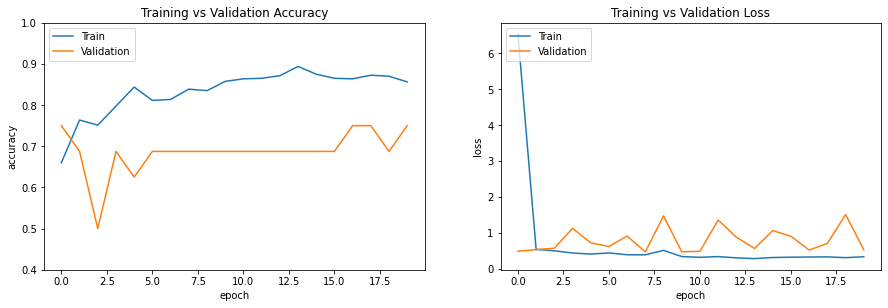

In [40]:
plt.figure(figsize = (15,10))

plt.subplot(2, 2, 1)
plt.plot(accuracy, label = "Training Accuracy")
plt.plot(val_accuracy, label = "Validation Accuracy")
plt.ylim(0.4, 1)
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')


plt.subplot(2, 2, 2)
plt.plot(loss, label = "Training Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.title("Training vs Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')

plt.show()

# **Saving the Model**

In [41]:
model.save('model2')

INFO:tensorflow:Assets written to: model2/assets
